In [1]:
### import modules
import illustris_python as il
import numpy as np
from scipy.signal import argrelextrema
import h5py
import rohr_utils as ru 
import os
import glob
import multiprocessing as mp
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib notebook 

global sim, basePath, fname, direc
global tlim, radii_binwidth, key
global scalar_keys, dset_keys
global rmin_norm, rmax_norm, radii_bins_norm, radii_bincents_norm, nbins
global tracer_ptn, star_ptn, gas_ptn, bh_ptn, bary_ptns
global jellyscore_min

tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
radii_binwidth = 0.1
key = 'inspected'

scalar_keys = ['SubhaloColdGasMass', 'SubhaloGasMass', 'SubhaloHotGasMass']
dset_keys = ['radii', 'mass_shells', 'vol_shells', 'densities_shells']

### define radial bins and bincenters ###
rmin_norm = 10.**(-1.) # [r/rgal]
rmax_norm = 10.**(2.)  # [r/rgal]
    
radii_bins_norm, radii_bincents_norm = ru.returnlogbins([rmin_norm, rmax_norm], radii_binwidth)
            
# prepend 0 to the radial bins to capture the center sphere
radii_bins_norm     = np.insert(radii_bins_norm, 0, 0.)
radii_bincents_norm = np.insert(radii_bincents_norm, 0, radii_bins_norm[1]/2.)

nbins = len(radii_bins_norm)

tracer_ptn = il.util.partTypeNum('tracer')
star_ptn   = il.util.partTypeNum('star')
gas_ptn    = il.util.partTypeNum('gas')
bh_ptn     = il.util.partTypeNum('bh')

bary_ptns   = [gas_ptn,
               star_ptn,
               bh_ptn]

jellyscore_min = 16


In [2]:
def load_dict(key, clean=False):
    
    # key == [inspected, jellyfish, nonjellyf] -- otherwise file doesn't exist
    fname = return_outfname(sim=sim, key=key, zooniverse=zooniverse, clean=clean)
    
    result = {}
        
    with h5py.File(outdirec + fname, 'a') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
        
    return result

def return_outfname(sim='TNG50-1', key='inspected', zooniverse=True, clean=False):
    """
    return the output filename.
    """
    if not zooniverse:
        outfname = 'subfind_%s_branches.hdf5'%sim
        return outfname
    else:
        outfname = 'zooniverse_%s_%s_branches'%(sim, key)
        if clean:
            outfname += '_clean.hdf5'
        else:
            outfname += '.hdf5'
        return outfname


In [3]:
sim = 'TNG50-1'
basePath = ru.ret_basePath(sim)
fname = 'zooniverse_%s_%s_branches.hdf5'%(sim, key)

direc = '../Output/%s_subfindGRP/'%sim


In [4]:
def add_tracers_postprocessing():
    """
    post process the tracer quantities
    """
    
    f = h5py.File(direc+fname, 'a')
    f_keys = np.array(list(f.keys()))
    
    result = np.ones(f[f_keys[0]]['SnapNum'].size, dtype=float) * -1.

    keys = ['RPS_int_tot',
            'SFR_int_tot',
            'sRPS',
            'sSFR']

    tracer_key = 'SubhaloColdGasTracer_Mass'
    RPS_key = 'SubhaloColdGasTracer_StripTot'
    SFR_key = 'SubhaloSFR'
    SCGM_key = 'SubhaloColdGasMass'


    for group_i, group_key in enumerate(f_keys):
        group = f[group_key]

        RPS_int_tot = result.copy()
        SFR_int_tot = result.copy()
        sRPS = result.copy()
        sSFR = result.copy()
        
        subhalo_indices = np.where((group['SubfindID'][:] != -1) & (group[tracer_key][:] != -1))[0]
        
        SCGM_flag = False
        
        if subhalo_indices.size > 1:
            
            SCGM = group[SCGM_key][subhalo_indices]
            if 0 in SCGM:
                SCGM_flag = True
                start_index = np.where(SCGM == 0)[0].max()                
                subhalo_indices = subhalo_indices[start_index:]
                SCGM = SCGM[start_index:]
                
            if subhalo_indices.size > 1:

                CosmicTimes = group['CosmicTime'][subhalo_indices]
                RPS = group[RPS_key][subhalo_indices]
                SFR = group[SFR_key][subhalo_indices]
                SCGM = group[SCGM_key][subhalo_indices]
                time_diffs = (CosmicTimes[:-1] - CosmicTimes[1:]) * 1.0e9

                save_indices = subhalo_indices[:-1]
                RPS_int_tot[save_indices] = np.cumsum((RPS[:-1] * time_diffs)[::-1])[::-1]
                SFR_int_tot[save_indices] = np.cumsum((SFR[:-1] * time_diffs)[::-1])[::-1]

                # calculate the specific RPS + outflows, SFR rate over all time
                calc_indices = (RPS >= 0) & (SCGM > 0)
                if calc_indices[calc_indices].size > 0:
                    save_indices = subhalo_indices[calc_indices]
                    sRPS[save_indices] = RPS[calc_indices] / SCGM[calc_indices]

                calc_indices = (SFR >= 0) & (SCGM > 0)
                if calc_indices[calc_indices].size > 0:
                    save_indices = subhalo_indices[calc_indices]
                    sSFR[save_indices] = SFR[calc_indices] / SCGM[calc_indices]
                    
            if (SCGM_flag):
                subhalo_indices = np.where(group['SubfindID'][:] != -1)[0]
                RPS_int_tot[subhalo_indices[:start_index+1]] = RPS_int_tot[subhalo_indices[start_index]]
                SFR_int_tot[subhalo_indices[:start_index+1]] = SFR_int_tot[subhalo_indices[start_index]]
                sRPS[subhalo_indices[:start_index+1]] = 0
                sSFR[subhalo_indices[:start_index+1]] = 0
            

        dsets = [RPS_int_tot, SFR_int_tot, sRPS, sSFR]
        for dset_index, dset_key in enumerate(keys):
            dset = dsets[dset_index]
            dataset = group.require_dataset(dset_key, shape=dset.shape, dtype=dset.dtype)
            dataset[:] = dset
            
    f.close()
    
    return
    


In [5]:
#add_tracers_postprocessing()

In [6]:
sim = 'TNG50-1'
zooniverse = True
outdirec = '../Output/%s_subfindGRP/'%sim

grp_dict = load_dict('jellyfish', clean=True)
grp_dict_keys = np.array(list(grp_dict.keys()))



In [7]:
group_key = grp_dict_keys[1]
group_key = '%08d'%(5)
group = grp_dict[group_key]
ins_flags = group['ins_flags']
latest_index = np.where(ins_flags)[0].min()
snap = group['SnapNum'][latest_index]
subfindID = group['SubfindID'][latest_index]
result_key = '%03d_%08d'%(snap, subfindID)
print(result_key)

084_00000007


In [8]:
group['jel_flags'].max()

1

In [9]:
    f = h5py.File(direc+fname, 'a')
    f_keys = np.array(list(f.keys()))

    result = np.ones(f[f_keys[0]]['SnapNum'].size, dtype=float) * -1.

    keys = ['tau_RPS_tot',
            'tau_RPS_est',
            'tau_RPS_sRPS']

    # define the number of points to use for smoothing via running median
    N_RM = 7
    
    tracer_key = 'SubhaloColdGasTracer_Mass'
    RPS_key = 'SubhaloColdGasTracer_StripTot'
    SFR_key = 'SubhaloSFR'
    SCGM_key = 'SubhaloColdGasMass'
    
    RPS_int_tot_key = 'RPS_int_tot'
    SFR_int_tot_key = 'SFR_int_tot'
    sRPS_key = 'sRPS'
    sSFR_key = 'sSFR'


In [10]:
group_key = result_key
group = f[group_key]


In [11]:

        
        # initalize results
        tau_RPS_tot = result.copy()
        tau_RPS_est = result.copy()
        tau_RPS_sRPS = result.copy()

        # start with the last snapshot that the galaxy was a central 
        # this is the same as one snapshot before infall 
        subhalo_indices = np.where(group['SubfindID'][:] != -1)[0]

        infall_index = np.where(group['memberlifof_flags'][subhalo_indices] == 1)[0].max() + 1
        
        calc_indices = subhalo_indices[:infall_index]
        
        ### tau_RPS_tot
        # check that there is a well defined infall time and some snaps afterwards 
        if (infall_index < subhalo_indices.size) & (calc_indices.size > 1):
            # now let's start the clock at the infall
            RPS_int_tot = group[RPS_int_tot_key][calc_indices]
            tau_RPS_tot[calc_indices] = RPS_int_tot / RPS_int_tot[0] * 100.
            tau_RPS_tot[subhalo_indices[infall_index]] = 0

        ### tau_RPS_est
        # check that there are at least N_RM snaps before infall to calc eta
        # note that the there is no calculated RPS + outflows for the last snpshot
        if subhalo_indices[infall_index:-1].size > N_RM:
            SFR = group[SFR_key][subhalo_indices][infall_index:-1]
            out = group[RPS_key][subhalo_indices][infall_index:-1]
            calc_indices = (SFR > 0) & (out >= 0)

            if calc_indices[calc_indices].size > 0:
                eta = np.median(out[calc_indices] / SFR[calc_indices])
                out_est = eta * group[SFR_key][subhalo_indices]
                RPS = group[RPS_key][subhalo_indices]
                                
                RPS_RM = ru.RunningMedian(RPS, N_RM)
                out_est_RM = ru.RunningMedian(out_est, N_RM)

                RPS_RM_peakindex = (RPS_RM[:infall_index] - out_est_RM[:infall_index]).argmax()
                diff = RPS_RM[RPS_RM_peakindex:] - out_est_RM[RPS_RM_peakindex:]
                tau0 = np.where(diff < 0)[0].min()
                tau0_index = subhalo_indices[RPS_RM_peakindex:][tau0]
                
                # ensure tau0 is before z=0
                if tau0 > 0:
                    SFR_int_tot = group[SFR_int_tot_key][subhalo_indices]
                    SFR_int_tot -= SFR_int_tot[tau0_index]
                    SFR_int_tot[tau0_index:] = 0.
                    RPS_est_cumsum = group[RPS_int_tot_key][subhalo_indices]
                    RPS_est_cumsum -= RPS_est_cumsum[tau0_index]
                    RPS_est_cumsum[tau0_index:] = 0
                    RPS_est_cumsum[:tau0_index] -= eta * SFR_int_tot[:tau0_index]
                    RPS_est_cumsum[RPS_est_cumsum < 0] = 0

                    tau_RPS_est[subhalo_indices[:tau0_index]] = (RPS_est_cumsum[:tau0_index] / RPS_est_cumsum[:tau0_index][0]) * 100.
                    tau_RPS_est[subhalo_indices[tau0_index]] = 0.

                    tau0_index_RPS_est = tau0_index

        ### tau_sRPS
        # check that there are at least N_RM snaps before infall to calc avg specific RPS + outflows
        if subhalo_indices[infall_index:-1].size > N_RM:
            sRPS = group[sRPS_key][subhalo_indices]
            calc_indices = np.where(sRPS[infall_index:-1] >= 0)[0]
            
            if calc_indices.size > 0:
                avg_sRPS = np.median(sRPS[infall_index:-1][calc_indices])
                
                calc_indices = sRPS >= 0
                sRPS_RM = ru.RunningMedian(sRPS[calc_indices], N_RM)
                
                sRPS_RM_peakindex = sRPS_RM[:infall_index].argmax()

                diff = sRPS_RM[sRPS_RM_peakindex:] - avg_sRPS
                
                
                if diff[diff <= 0].size > 0:
                
                    tau0 = np.where(diff <= 0)[0].min()
                    tau0_index = subhalo_indices[calc_indices][sRPS_RM_peakindex:][tau0]

                    SCGM = group[SCGM_key][subhalo_indices]

                    if 0 in SCGM[calc_indices][:sRPS_RM_peakindex]:
                        tau100_index = subhalo_indices[np.where(SCGM == 0)[0].max()]
                    else:
                        tau100_index = subhalo_indices[0]

                    tau_RPS_sRPS[:tau100_index+1] = 100.
                    tau_RPS_sRPS[tau100_index+1:tau0_index] = 50.
                    tau_RPS_sRPS[tau0_index] = 0.

                    tau0_index_RPS_sRPS = tau0_index
 

<IPython.core.display.Javascript object>


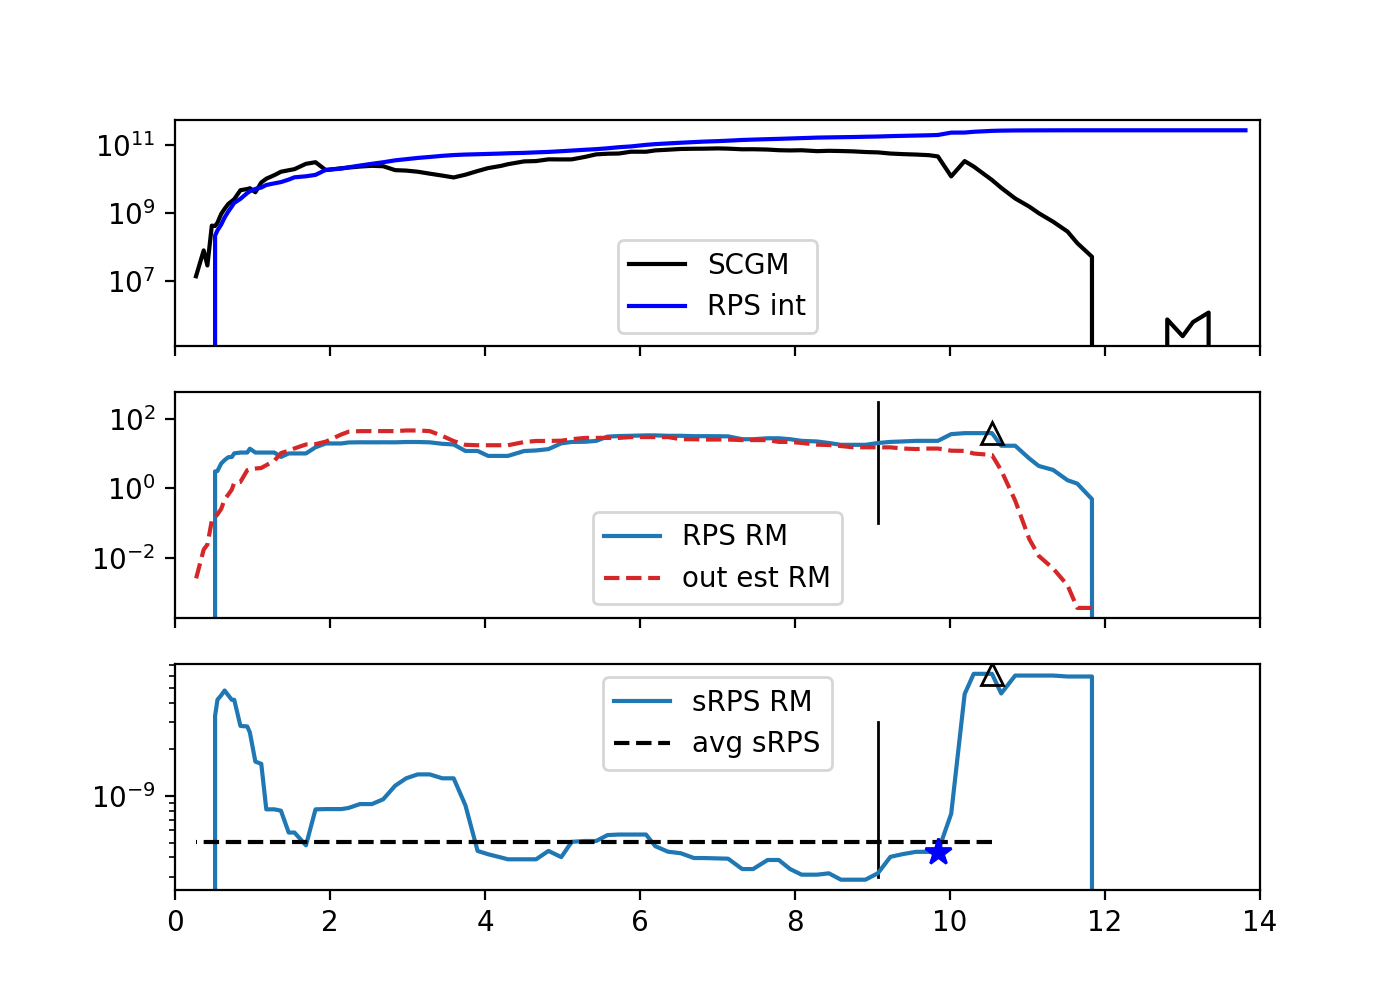

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(7,5), sharex=True)

subhalo_indices = np.where(group['SubfindID'][:] != -1)[0]

RPS_int_tot = group[RPS_int_tot_key][subhalo_indices]
SCGM = group[SCGM_key][subhalo_indices]
CosmicTime = group['CosmicTime'][subhalo_indices]
RPS = group[RPS_key][subhalo_indices]
SFR = group[SFR_key][subhalo_indices]

axs[0].plot(CosmicTime, SCGM, 'k-', label='SCGM')
axs[0].plot(CosmicTime, RPS_int_tot, 'b-', label='RPS int')
axs[0].set_yscale('log')
axs[0].legend()

plot_indices = np.where(RPS != -1)[0]
axs[1].plot(CosmicTime[plot_indices[:-1]], RPS_RM[plot_indices[:-1]],
            c='tab:blue', ls='-', marker='None', label='RPS RM')
axs[1].plot(CosmicTime[out_est_RM > 0], out_est_RM[out_est_RM > 0],
            c='tab:red', marker='None', ls='--', label='out est RM')

axs[1].plot(CosmicTime[RPS_RM_peakindex], RPS_RM[RPS_RM_peakindex], marker='^', c='k', fillstyle='none', ms=8)
#axs[1].plot(CosmicTime[tau0_index_RPS_est], RPS_RM[tau0_index_RPS_est], marker='*', ms=10, c='b')
axs[1].plot([CosmicTime[infall_index], CosmicTime[infall_index]], [1.0e-1, 3.0e2], 'k-', lw=1, zorder=1) 

axs[1].set_yscale('log')
axs[1].legend()

axs[1].set_xlim(0.0, 14.0)

axs[2].plot(CosmicTime[calc_indices][:-1], sRPS_RM[:-1], c='tab:blue', ls='-', marker='None', label='sRPS RM')
axs[2].plot(CosmicTime[calc_indices][sRPS_RM_peakindex:],
            np.ones(CosmicTime[calc_indices][sRPS_RM_peakindex:].size)*avg_sRPS, 'k--', label='avg sRPS')
axs[2].plot(CosmicTime[tau0_index_RPS_sRPS], sRPS_RM[tau0_index_RPS_sRPS], marker='*', ms=10, c='b')
axs[2].plot(CosmicTime[sRPS_RM_peakindex], sRPS_RM[sRPS_RM_peakindex], marker='^', c='k', fillstyle='none', ms=8)
axs[2].plot([CosmicTime[infall_index], CosmicTime[infall_index]], [3.0e-10, 3.0e-9], 'k-', lw=1, zorder=1) 

axs[2].set_yscale('log')
axs[2].legend()

In [ ]:
def add_coldgasmasstracerstau():
    """
    add tau clock definitions based on the tracer quantities.
    must be called after adding time and tracer datasets.
    There are two tau definitions using the tracers:
    (i) tau_RPS_tot_infall
    starting one snapshot before infall,
    integrate RPS + outflows until z_x. tau_x is when the integral
    reaches x% of the integral until z=0.
    (ii) tau_RPS_est_infall
    calcualte the mass loading factor median(RPS + outflows / SFR)
    when the galaxy was a central, and use this to estimate the 
    outflows when the galaxy is a satellite. Then the difference
    between the estimated outflows and the measured RPS + outflows
    is the RPS. integrate this from infall until z=0 and use the
    same tau_x clock as definition (i).
    (iii) tau_RPS_sRPS
    find the peak in the (RPS + outflows) / M_ColdGas after infall,
    and then define tau_0 as when RPS + outflows = the average 
    (RPS + outflows) before infall, and tau_100 as the first of:
    a) (RPS + outflows) / M_ColdGas < 1 / t_H, t_H = Hubble Time
    b) M_ColdGas reaches 0;
    c) z=0
    """
    
    f = h5py.File(direc+fname, 'a')
    f_keys = np.array(list(f.keys()))

    result = np.ones(f[f_keys[0]]['SnapNum'].size, dtype=float) * -1.

    keys = ['tau_RPS_tot',
            'tau_RPS_est',
            'tau_RPS_sRPS']

    # define the number of points to use for smoothing via running median
    N_RM = 7
    
    tracer_key = 'SubhaloColdGasTracer_Mass'
    RPS_key = 'SubhaloColdGasTracer_StripTot'
    SFR_key = 'SubhaloSFR'
    SCGM_key = 'SubhaloColdGasMass'
    
    RPS_int_tot_key = 'RPS_int_tot'
    SFR_int_tot_key = 'SFR_int_tot'
    sRPS_key = 'sRPS'
    sSFR_key = 'sSFR'


    for group_index, group_key in enumerate(f_keys):
        group = f[group_key]

        # initalize results
        tau_RPS_tot = result.copy()
        tau_RPS_est = result.copy()
        tau_RPS_sRPS = result.copy()

        # start with the last snapshot that the galaxy was a central 
        # this is the same as one snapshot before infall 
        subhalo_indices = np.where(group['SubfindID'][:] != -1)[0]

        infall_index = np.where(group['memberlifof_flags'][subhalo_indices] == 1)[0].max() + 1
        
        calc_indices = subhalo_indices[:infall_index]
        
        ### tau_RPS_tot
        # check that there is a well defined infall time and some snaps afterwards 
        if (infall_index < subhalo_indices.size) & (calc_indices.size > 1):
            # now let's start the clock at the infall
            RPS_int_tot = group[RPS_int_tot_key][calc_indices]
            tau_RPS_tot[calc_indices] = RPS_int_tot / RPS_int_tot[0] * 100.
            tau_RPS_tot[subhalo_indices[infall_index]] = 0

        ### tau_RPS_est
        # check that there are at least N_RM snaps before infall to calc eta
        # note that the there is no calculated RPS + outflows for the last snpshot
        if subhalo_indices[infall_index:-1].size > N_RM:
            SFR = group[SFR_key][subhalo_indices][infall_index:-1]
            out = group[RPS_key][subhalo_indices][infall_index:-1]
            calc_indices = (SFR > 0) & (out >= 0)

            if calc_indices[calc_indices].size > 0:
                eta = np.median(out[calc_indices] / SFR[calc_indices])
                out_est = eta * group[SFR_key][subhalo_indices]
                RPS = group[RPS_key][subhalo_indices]
                                
                RPS_RM = ru.RunningMedian(RPS, N_RM)
                out_est_RM = ru.RunningMedian(out_est, N_RM)

                RPS_RM_peakindex = RPS_RM[:infall_index].argmax()
                diff = RPS_RM[RPS_RM_peakindex:] - out_est_RM[RPS_RM_peakindex:]
                tau0 = np.where(diff < 0)[0].min()
                tau0_index = subhalo_indices[RPS_RM_peakindex:][tau0]
                
                # ensure tau0 is before z=0
                if tau0 > 0:
                    SFR_int_tot = group[SFR_int_tot_key][subhalo_indices]
                    SFR_int_tot -= SFR_int_tot[tau0_index]
                    SFR_int_tot[tau0_index:] = 0.
                    RPS_est_cumsum = group[RPS_int_tot_key][subhalo_indices]
                    RPS_est_cumsum -= RPS_est_cumsum[tau0_index]
                    RPS_est_cumsum[tau0_index:] = 0
                    RPS_est_cumsum[:tau0_index] -= eta * SFR_int_tot[:tau0_index]
                    RPS_est_cumsum[RPS_est_cumsum < 0] = 0

                    tau_RPS_est[subhalo_indices[:tau0_index]] = (RPS_est_cumsum[:tau0_index] / RPS_est_cumsum[:tau0_index][0]) * 100.
                    tau_RPS_est[subhalo_indices[tau0_index]] = 0.

                    tau0_index_RPS_est = tau0_index

        ### tau_sRPS
        # check that there are at least N_RM snaps before infall to calc avg specific RPS + outflows
        if subhalo_indices[infall_index:-1].size > N_RM:
            sRPS = group[sRPS_key][subhalo_indices]
            calc_indices = np.where(sRPS[infall_index:-1] >= 0)[0]
            
            if calc_indices.size > 0:
                avg_sRPS = np.median(sRPS[infall_index:-1][calc_indices])
                
                calc_indices = sRPS >= 0
                sRPS_RM = ru.RunningMedian(sRPS[calc_indices], N_RM)
                
                sRPS_RM_peakindex = sRPS_RM[:infall_index].argmax()

                diff = sRPS_RM[sRPS_RM_peakindex:] - avg_sRPS
                
                
                if diff[diff <= 0].size > 0:
                
                    tau0 = np.where(diff <= 0)[0].min()
                    tau0_index = subhalo_indices[calc_indices][sRPS_RM_peakindex:][tau0]

                    SCGM = group[SCGM_key][subhalo_indices]

                    if 0 in SCGM[calc_indices][:sRPS_RM_peakindex]:
                        tau100_index = subhalo_indices[np.where(sRPS == 0)[0].max()]
                    else:
                        tau100_index = subhalo_indices[0]

                    tau_RPS_sRPS[:tau100_index+1] = 100.
                    tau_RPS_sRPS[tau100_index+1:tau0_index] = 50.
                    tau_RPS_sRPS[tau0_index] = 0.

                    tau0_index_RPS_sRPS = tau0_index
            
        # save the output
        dsets = [tau_RPS_tot,
                 tau_RPS_est,
                 tau_RPS_sRPS]
        
        for dset_index, dset_key in enumerate(keys):
            dset = dsets[dset_index]
            dataset = group.require_dataset(dset_key, shape=dset.shape, dtype=dset.dtype)
            dataset[:] = dset        
    
    # finish loop over branches
    f.close()

    return
    

In [ ]:
OV_dict = load_dict('inspected', clean=False)
OV_dict_keys = np.array(list(OV_dict.keys()))OV_key = '077_00000001'
group = OV_dict[OV_key]
SnapNum = group['SnapNum']
if SnapNum.max() == 99:
    key = group['SubfindID'][0]
    print(key)
    if group['jel_flags'].max() == 1:
        print('jellyfish')
    else:
        print('nonjellyf')
else:
    print('Does not reach z=0')
